In [1]:
import torch
import joblib
import pickle
import sklearn

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
from sklearn import svm
from sklearn import tree

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Static Analysis

In [2]:
df = pd.read_csv("data/train.csv", sep=";")

In [3]:
df = df.astype("int64")
df.type.value_counts()

0    199
1    199
Name: type, dtype: int64

In [4]:
df.shape

(398, 331)

*Malicious*

In [5]:
mal_ser = pd.Series.sort_values(df[df.type==1].sum(axis=0), ascending=False)[1:11]
print(mal_ser)

android.permission.INTERNET                  195
android.permission.READ_PHONE_STATE          190
android.permission.ACCESS_NETWORK_STATE      167
android.permission.WRITE_EXTERNAL_STORAGE    136
android.permission.ACCESS_WIFI_STATE         135
android.permission.READ_SMS                  124
android.permission.WRITE_SMS                 104
android.permission.RECEIVE_BOOT_COMPLETED    102
android.permission.ACCESS_COARSE_LOCATION     80
android.permission.CHANGE_WIFI_STATE          75
dtype: int64


*Benign*

In [6]:
ben_ser = pd.Series.sort_values(df[df.type==0].sum(axis=0), ascending=False)[:10]
ben_ser

android.permission.INTERNET                  104
android.permission.WRITE_EXTERNAL_STORAGE     76
android.permission.ACCESS_NETWORK_STATE       62
android.permission.WAKE_LOCK                  36
android.permission.RECEIVE_BOOT_COMPLETED     30
android.permission.ACCESS_WIFI_STATE          29
android.permission.READ_PHONE_STATE           24
android.permission.VIBRATE                    21
android.permission.ACCESS_FINE_LOCATION       18
android.permission.READ_EXTERNAL_STORAGE      15
dtype: int64

In [7]:
permissions = []

for index in mal_ser.index:
    if index not in permissions:
        permissions.append(index)
    
for index in ben_ser.index:
    if index not in permissions:
        permissions.append(index)
        
permissions, len(permissions)

(['android.permission.INTERNET',
  'android.permission.READ_PHONE_STATE',
  'android.permission.ACCESS_NETWORK_STATE',
  'android.permission.WRITE_EXTERNAL_STORAGE',
  'android.permission.ACCESS_WIFI_STATE',
  'android.permission.READ_SMS',
  'android.permission.WRITE_SMS',
  'android.permission.RECEIVE_BOOT_COMPLETED',
  'android.permission.ACCESS_COARSE_LOCATION',
  'android.permission.CHANGE_WIFI_STATE',
  'android.permission.WAKE_LOCK',
  'android.permission.VIBRATE',
  'android.permission.ACCESS_FINE_LOCATION',
  'android.permission.READ_EXTERNAL_STORAGE'],
 14)

The original source does not create the permissions list that we created above. This means that when they plot the axes below and set sharex=True there is a mismatch between the x-axes. We changed this to highlight the difference between access request of malicious and benign apps. We also set titles to make the visualisation more clear.

Text(0.5, 1.0, 'Malicious Apps')

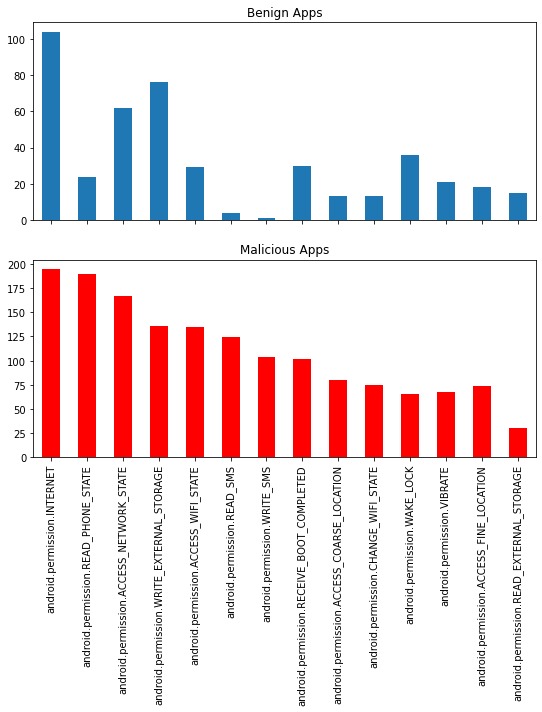

In [43]:
fig, axs =  plt.subplots(nrows=2,sharex=True, figsize=(9,8))

pd.Series.sort_values(df[df.type==0].sum(axis=0), ascending=False)[permissions].plot.bar(ax=axs[0])
axs[0].set_title('Benign Apps')
pd.Series.sort_values(df[df.type==1].sum(axis=0), ascending=False)[permissions].plot.bar(ax=axs[1], color="red")
axs[1].set_title('Malicious Apps')

## Static Analysis Modelling

Here we look at the performance of different classifier models.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:330], df['type'], test_size=0.20, random_state=42)

#### Naive Bayes

In [10]:
# Naive Bayes algorithm
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# pred
pred = gnb.predict(X_test)

# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

naive_bayes
0.8375
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        41
           1       0.78      0.92      0.85        39

    accuracy                           0.84        80
   macro avg       0.85      0.84      0.84        80
weighted avg       0.85      0.84      0.84        80



#### KNeighbours

In [11]:
# kneighbors algorithm

for i in range(3,15,3):
    
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    # accuracy
    accuracy = accuracy_score(pred, y_test)
    print("kneighbors {}".format(i))
    print(accuracy)
    print(classification_report(pred, y_test, labels=None))
    print("")

kneighbors 3
0.8875
              precision    recall  f1-score   support

           0       0.94      0.82      0.88        39
           1       0.85      0.95      0.90        41

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80


kneighbors 6
0.85
              precision    recall  f1-score   support

           0       0.94      0.76      0.84        42
           1       0.78      0.95      0.86        38

    accuracy                           0.85        80
   macro avg       0.86      0.85      0.85        80
weighted avg       0.87      0.85      0.85        80


kneighbors 9
0.8625
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        41
           1       0.80      0.95      0.87        39

    accuracy                           0.86        80
   macro avg       0.87      0.86      0.86        80
weighted avg  

#### Decision Tree

In [12]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Read the csv test file

pred = clf.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(clf)
print(accuracy)
print(classification_report(pred, y_test, labels=None))

DecisionTreeClassifier()
0.95
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        36
           1       0.93      0.98      0.96        44

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



## Dynamic Analysis

For this approach, we used a set of pcap files from the DroidCollector project integrated by 4705 benign and 7846 malicious applications. All of the files were processed by our feature extractor script (a result from [4]), the idea of this analysis is to answer the next question, according to the static analysis previously seen a lot of applications use a network connection, in other words, they are trying to communicate or transmit information, so.. is it possible to distinguish between malware and benign application using network traffic?

In [13]:
data = pd.read_csv('data/android_traffic.csv',sep=';')

In [14]:
data.head()

,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,NaN,NaN,NaN,39,3,benign
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,NaN,NaN,NaN,128,11,benign
2,AntiVirus,196,0,6,24151,0,0,205,214,163887,24867,NaN,NaN,NaN,205,9,benign
3,AntiVirus,6,0,1,889,0,0,7,6,819,975,NaN,NaN,NaN,7,1,benign
4,AntiVirus,6,0,1,882,0,0,7,6,819,968,NaN,NaN,NaN,7,1,benign


In [15]:
data.columns

Index(['name', 'tcp_packets', 'dist_port_tcp', 'external_ips', 'vulume_bytes',
       'udp_packets', 'tcp_urg_packet', 'source_app_packets',
       'remote_app_packets', 'source_app_bytes', 'remote_app_bytes',
       'duracion', 'avg_local_pkt_rate', 'avg_remote_pkt_rate',
       'source_app_packets.1', 'dns_query_times', 'type'],
      dtype='object')

In [16]:
data.shape

(7845, 17)

In [17]:
data.type.value_counts()

benign       4704
malicious    3141
Name: type, dtype: int64

## Cleaning

In [18]:
data.isna().sum()

name                       0
tcp_packets                0
dist_port_tcp              0
external_ips               0
vulume_bytes               0
udp_packets                0
tcp_urg_packet             0
source_app_packets         0
remote_app_packets         0
source_app_bytes           0
remote_app_bytes           0
duracion                7845
avg_local_pkt_rate      7845
avg_remote_pkt_rate     7845
source_app_packets.1       0
dns_query_times            0
type                       0
dtype: int64

In [19]:
data = data.drop(['duracion','avg_local_pkt_rate','avg_remote_pkt_rate'], axis=1).copy()

In [20]:
data.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times
count,7845.000000,7845.000000,7845.000000,7.845000e+03,7845.000000,7845.000000,7845.000000,7845.000000,7.845000e+03,7.845000e+03,7845.000000,7845.000000
mean,147.578713,7.738177,2.748502,1.654375e+04,0.056724,0.000255,152.911918,194.706310,2.024967e+05,1.692260e+04,152.911918,4.898917
std,777.920084,51.654222,2.923005,8.225650e+04,1.394046,0.015966,779.034618,1068.112696,1.401076e+06,8.238182e+04,779.034618,18.900478
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000e+00,6.900000e+01,1.000000,0.000000
25%,6.000000,0.000000,1.000000,8.880000e+02,0.000000,0.000000,7.000000,7.000000,9.340000e+02,1.046000e+03,7.000000,1.000000
50%,25.000000,0.000000,2.000000,3.509000e+03,0.000000,0.000000,30.000000,24.000000,4.090000e+03,3.803000e+03,30.000000,3.000000
75%,93.000000,0.000000,4.000000,1.218900e+04,0.000000,0.000000,98.000000,92.000000,2.624400e+04,1.261000e+04,98.000000,5.000000
max,37143.000000,2167.000000,43.000000,4.226790e+06,65.000000,1.000000,37150.000000,45928.000000,6.823516e+07,4.227323e+06,37150.000000,913.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tcp_urg_packet'>

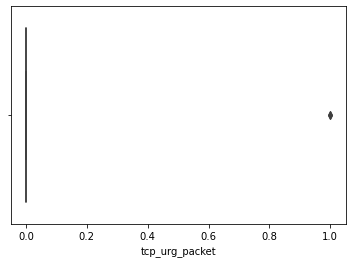

In [21]:
sns.boxplot(data.tcp_urg_packet)

In [22]:
data.loc[data.tcp_urg_packet > 0]

,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
1099,DailyLife,16,16,1,2024,0,1,16,18,2099,2024,16,0,benign
1100,DailyLife,22,22,1,2750,0,1,22,22,2804,2750,22,0,benign


The original source decided to drop the 'tcp_urg_packet' column due to all values being the same except for 2 apps. This changes the visualisation below; our visualisation has a redundant row 6 and column 6. However, we decided to keep the column to see if it has influence on modelling.

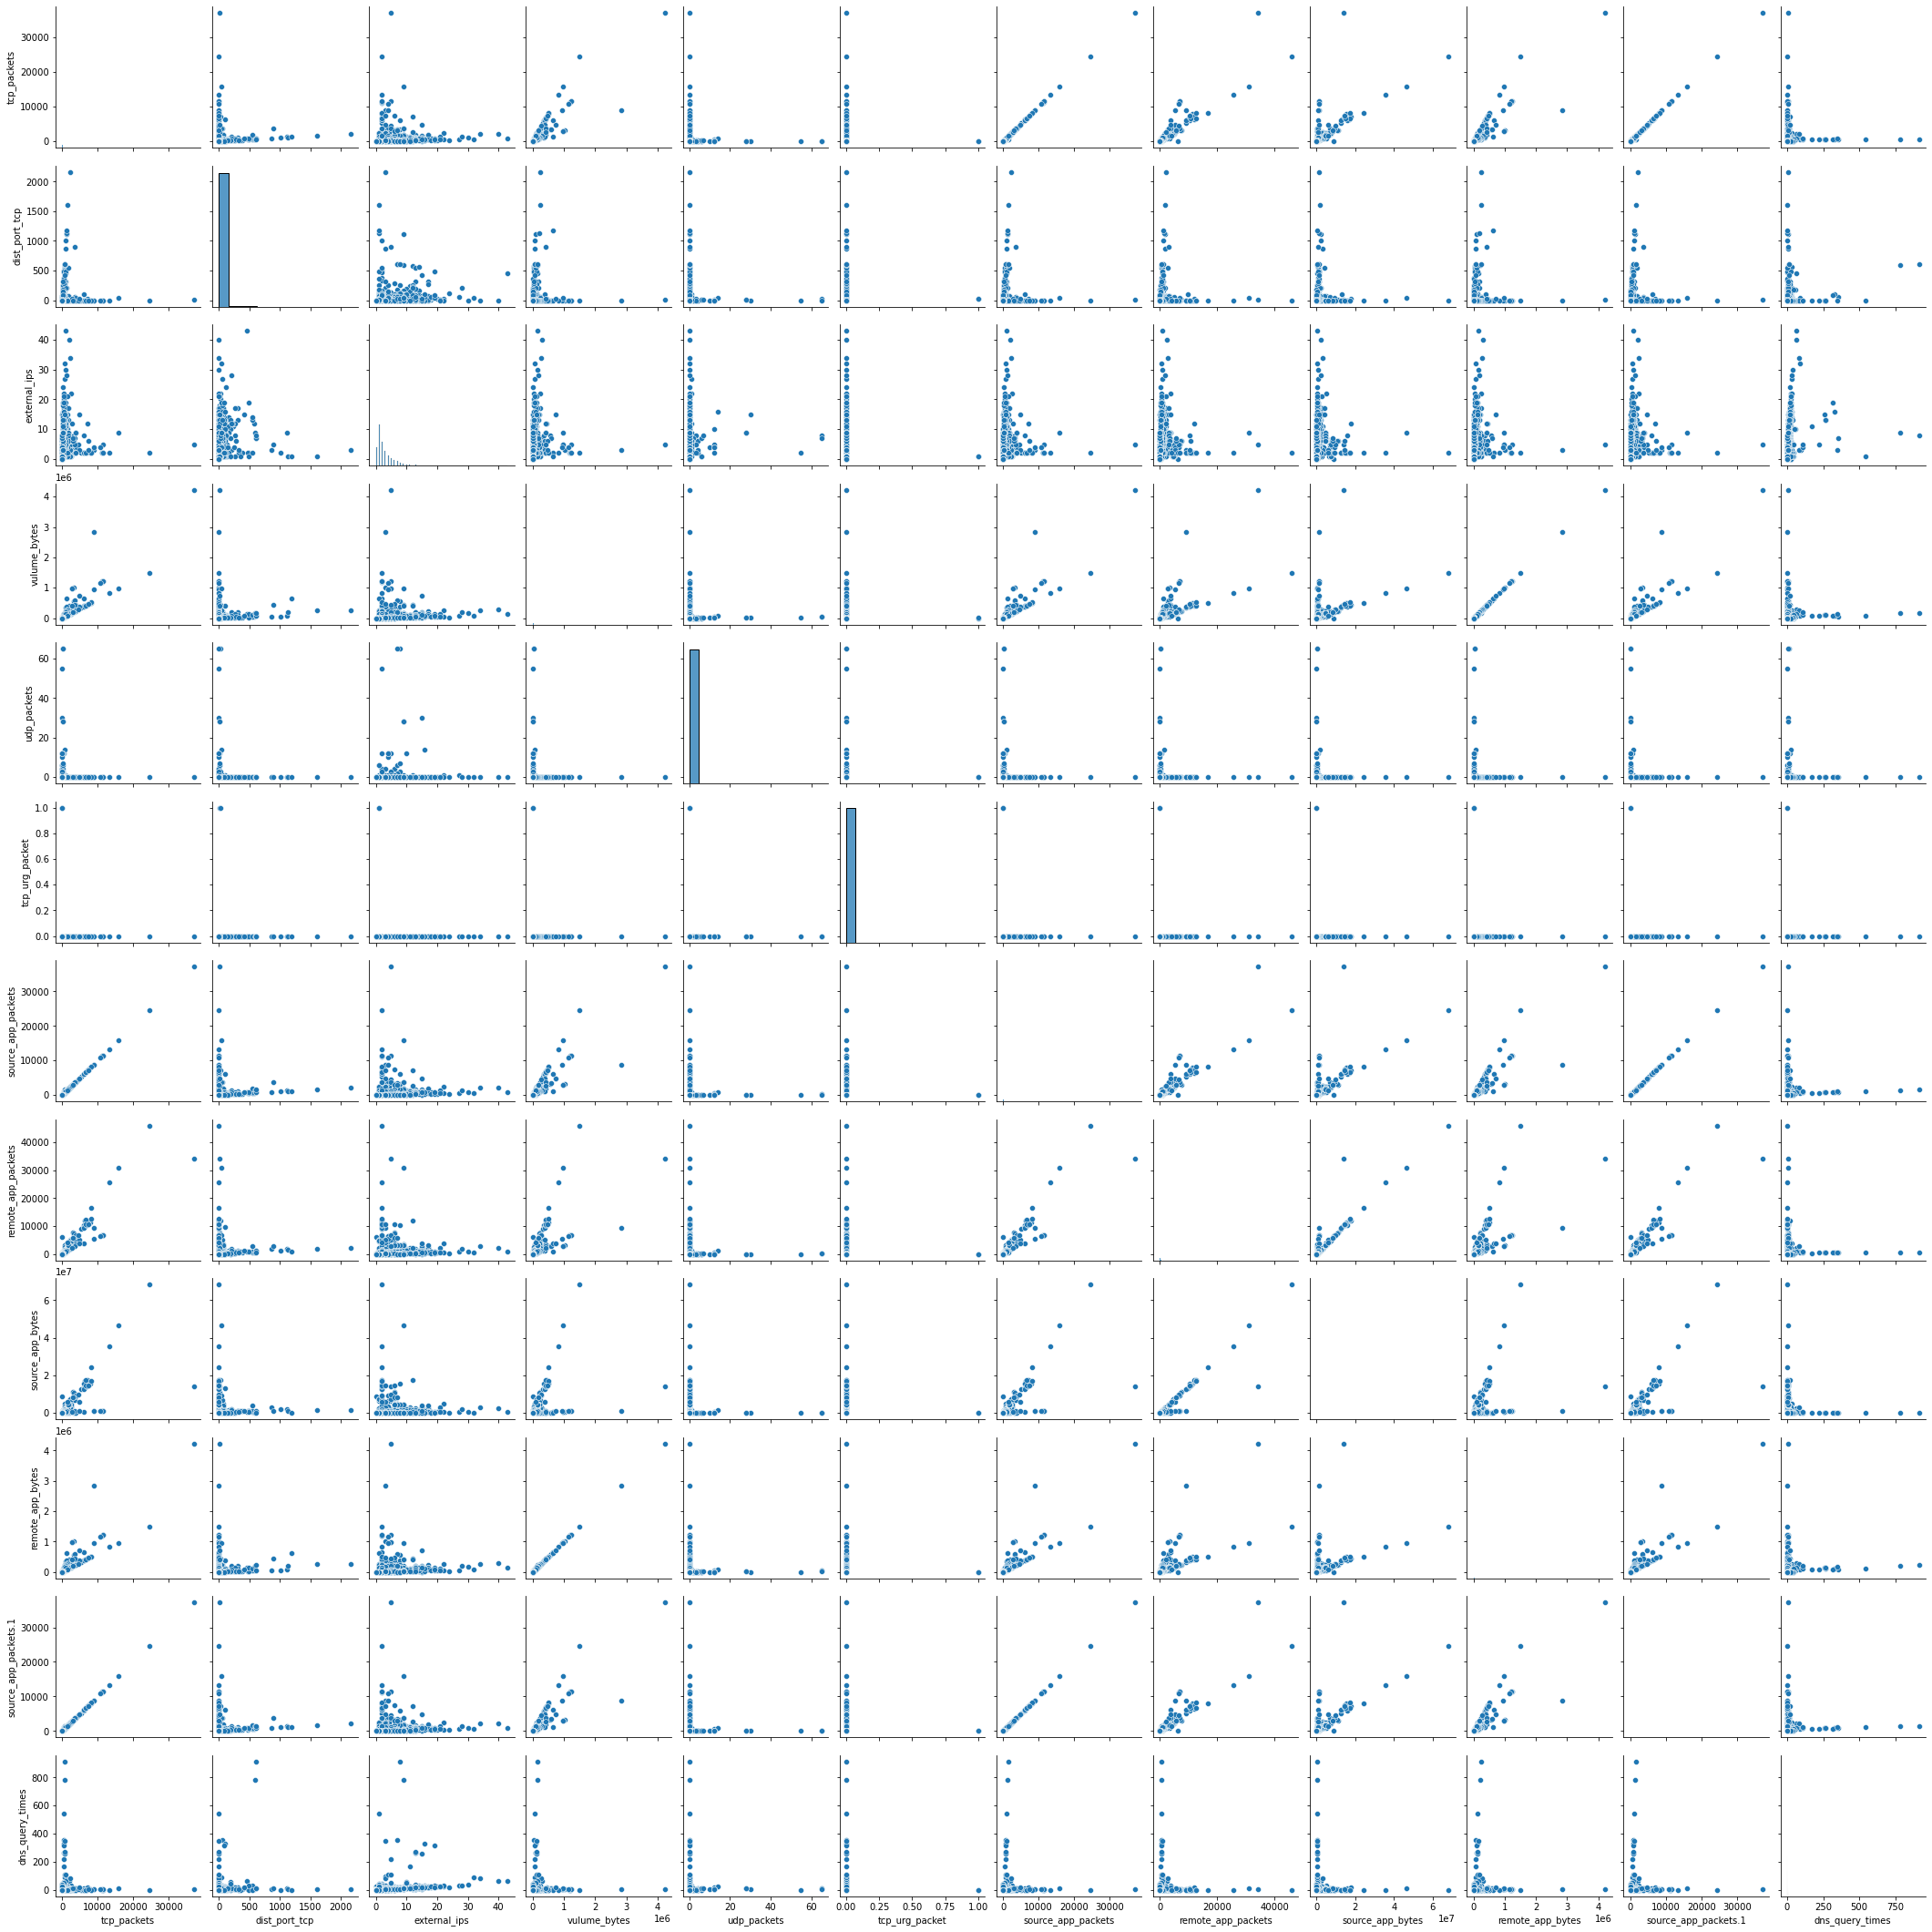

In [23]:
sns.pairplot(data)

In [24]:
data=data[data.tcp_packets<20000].copy()
data=data[data.dist_port_tcp<1400].copy()
data=data[data.external_ips<35].copy()
data=data[data.vulume_bytes<2000000].copy()
data=data[data.udp_packets<40].copy()
data=data[data.remote_app_packets<15000].copy()

In [25]:
data[data.duplicated()].sum()

name                    AntiVirusAntiVirusAntiVirusAntiVirusAntiVirusA...
tcp_packets                                                         15038
dist_port_tcp                                                        3514
external_ips                                                         1434
vulume_bytes                                                      2061210
udp_packets                                                            38
tcp_urg_packet                                                          0
source_app_packets                                                  21720
remote_app_packets                                                  18841
source_app_bytes                                                  8615120
remote_app_bytes                                                  2456160
source_app_packets.1                                                21720
dns_query_times                                                      5095
type                    benignbenignbe

In [26]:
data=data.drop('source_app_packets.1',axis=1).copy()

In [27]:
data.iloc[:,1:]

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times,type
0,36,6,3,3911,0,0,39,33,5100,4140,3,benign
1,117,0,9,23514,0,0,128,107,26248,24358,11,benign
2,196,0,6,24151,0,0,205,214,163887,24867,9,benign
3,6,0,1,889,0,0,7,6,819,975,1,benign
4,6,0,1,882,0,0,7,6,819,968,1,benign
...,...,...,...,...,...,...,...,...,...,...,...,...
7840,0,0,0,0,0,0,2,2,257,143,2,malicious
7841,4,4,1,296,0,0,5,1,86,382,1,malicious
7842,0,0,0,0,0,0,2,2,257,143,2,malicious
7843,0,0,0,0,0,0,2,2,257,143,2,malicious


In [28]:
scaler = preprocessing.RobustScaler()
scaledData = scaler.fit_transform(data.iloc[:,1:-1])
scaledData = pd.DataFrame(scaledData, columns=['tcp_packets','dist_port_tcp','external_ips','vulume_bytes',
                                               'udp_packets','tcp_urg_packet','source_app_packets','remote_app_packets',
                                               'source_app_bytes','remote_app_bytes','dns_query_times'])

## Dynamic Analysis Modelling

In [29]:
X_train, X_test, y_train, y_test = train_test_split(scaledData.iloc[:,0:10], data.type.astype("str"), 
                                                    test_size=0.25, random_state=45)

#### Naive Bayes

In [30]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)
## accuracy
accuracy = accuracy_score(y_test,pred)
print("naive_bayes")
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))

naive_bayes
0.4346271705822268
              precision    recall  f1-score   support

      benign       0.79      0.09      0.17      1190
   malicious       0.41      0.96      0.57       768

    accuracy                           0.43      1958
   macro avg       0.60      0.53      0.37      1958
weighted avg       0.64      0.43      0.33      1958

cohen kappa score
0.045014394137660285


#### KNeighbours

In [31]:
# kneighbors algorithm

for i in range(3,15,3):
    
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    # accuracy
    accuracy = accuracy_score(pred, y_test)
    print("kneighbors {}".format(i))
    print(accuracy)
    print(classification_report(pred, y_test, labels=None))
    print("cohen kappa score")
    print(cohen_kappa_score(y_test, pred))
    print("")

kneighbors 3
0.8871297242083759
              precision    recall  f1-score   support

      benign       0.91      0.91      0.91      1195
   malicious       0.85      0.86      0.86       763

    accuracy                           0.89      1958
   macro avg       0.88      0.88      0.88      1958
weighted avg       0.89      0.89      0.89      1958

cohen kappa score
0.7629890509549605

kneighbors 6
0.8845760980592441
              precision    recall  f1-score   support

      benign       0.93      0.89      0.91      1250
   malicious       0.81      0.88      0.85       708

    accuracy                           0.88      1958
   macro avg       0.87      0.88      0.88      1958
weighted avg       0.89      0.88      0.89      1958

cohen kappa score
0.7545059139427024

kneighbors 9
0.874361593462717
              precision    recall  f1-score   support

      benign       0.89      0.90      0.90      1186
   malicious       0.84      0.84      0.84       772

    accurac

#### Random Forests

In [32]:
rdF=RandomForestClassifier(n_estimators=250, max_depth=50,random_state=45)
rdF.fit(X_train,y_train)
pred=rdF.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(rdF)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))
print(cm)

RandomForestClassifier(max_depth=50, n_estimators=250, random_state=45)
0.9141981613891726
              precision    recall  f1-score   support

      benign       0.92      0.94      0.93      1190
   malicious       0.91      0.87      0.89       768

    accuracy                           0.91      1958
   macro avg       0.91      0.91      0.91      1958
weighted avg       0.91      0.91      0.91      1958

cohen kappa score
0.8188658299670049
[[1120   70]
 [  98  670]]
